# 0 Dataset

This dataset contains transaction data from a system, recorded over the course of one day. The information is captured in 60-second intervals. For each interval, the dataset includes:

- The number of transactions that occurred

- The minimum, maximum, and average processing time for the transactions

- The number of retries the system performed to successfully process transactions

- The number of failed transactions that were not submitted successfully

Our final goal is to develop an anomaly detection system. This system should be able to take a current time interval, predict transaction behavior in the near future, and apply anomaly detection techniques to the predicted values in order to identify unusual or abnormal transaction patterns.


# 1 Data Analysis

Before starting to develope our prediction and detection models, we have to obtain knowledge about the nature of the provided dataset with the given attributes.We will analyze the dataset structure to identify trends and see if there are any increasing or decreasing patterns over the day or not.

 - Seasonality: Are there any recurring patterns at specific times of the day (e.g., higher transaction volume during business hours)?
 - Stationarity: Does the statistical properties of the time series (mean, variance) remain constant over time?
 - Outliers: Are there any unusual spikes or drops in the values that might indicate anomalies?

We will also examine the distribution of each numerical variable using histograms or kernel density plots. This will give us insights into the typical range of values and the presence of any skewness.

## 1.1  Data loading

**Subtask**:
Load the dataset "FullDayWithAlarms.xlsx" into a pandas DataFrame.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#load the data
raw_df = pd.read_excel("FullDayWithAlarms.xlsx")
raw_df.head()

,SCOMMESSE VIRTUALI,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,COD \nGIOCO,DATA ORA,INTERVALLO\nACQUISIZIONE,NUMERO\nTRANSAZIONI,TEMPO MIN,TEMPO MAX,TEMPO MEDIO,NUMERO RETRY,NUMERO \nTRANSAZIONI ERRATE
1,8,31/05/2024 07:01:11,60,366,6,1019,25.907562,0,90
2,8,31/05/2024 07:02:11,60,948,7,90,18.181719,0,90
3,8,31/05/2024 07:03:11,60,1273,7,408,18.813356,0,90
4,8,31/05/2024 07:04:11,60,1538,6,70,16.607435,0,90


The data seems to have a header in the first row.  The next step is to read the data correctly, skipping the first row and setting the columns to English.

In [ ]:
#Drop the first header
raw_df = pd.read_excel("FullDayWithAlarms.xlsx", header=1)

# Rename columns to English for clarity
raw_df.rename(
    columns={
        "COD \nGIOCO": "Code_ID",
        "DATA ORA": "Timestamp",
        "INTERVALLO\nACQUISIZIONE": "Interval_s",
        "NUMERO\nTRANSAZIONI": "Num_Transactions",
        "TEMPO MIN": "Time_Min",
        "TEMPO MAX": "Time_Max",
        "TEMPO MEDIO": "Mean_Time",
        "NUMERO RETRY": "Num_Retries",
        "NUMERO \nTRANSAZIONI ERRATE": "Num_Wrong_Transactions",
    },
    inplace=True,
)

# # Parse and sort timestamps
raw_df["Timestamp"] = pd.to_datetime(
    raw_df["Timestamp"], dayfirst=True, errors="coerce"
)

#Display the first few rows of the DataFrame
raw_df.head()

,Code_ID,Timestamp,Interval_s,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions
0,8,2024-05-31 07:01:11,60,366,6,1019,25.907562,0,90
1,8,2024-05-31 07:02:11,60,948,7,90,18.181719,0,90
2,8,2024-05-31 07:03:11,60,1273,7,408,18.813356,0,90
3,8,2024-05-31 07:04:11,60,1538,6,70,16.607435,0,90
4,8,2024-05-31 07:05:11,60,703,5,85,16.645409,0,90


## 1.2 Basic Plots

### Subtask:
In this section we want to explore the dataset to understand its basic characteristics, including data shape, types, missing values, numerical feature analysis, and potential outliers.
The histograms visualize the distributions of numerical features, helping to identify potential outliers and skewness


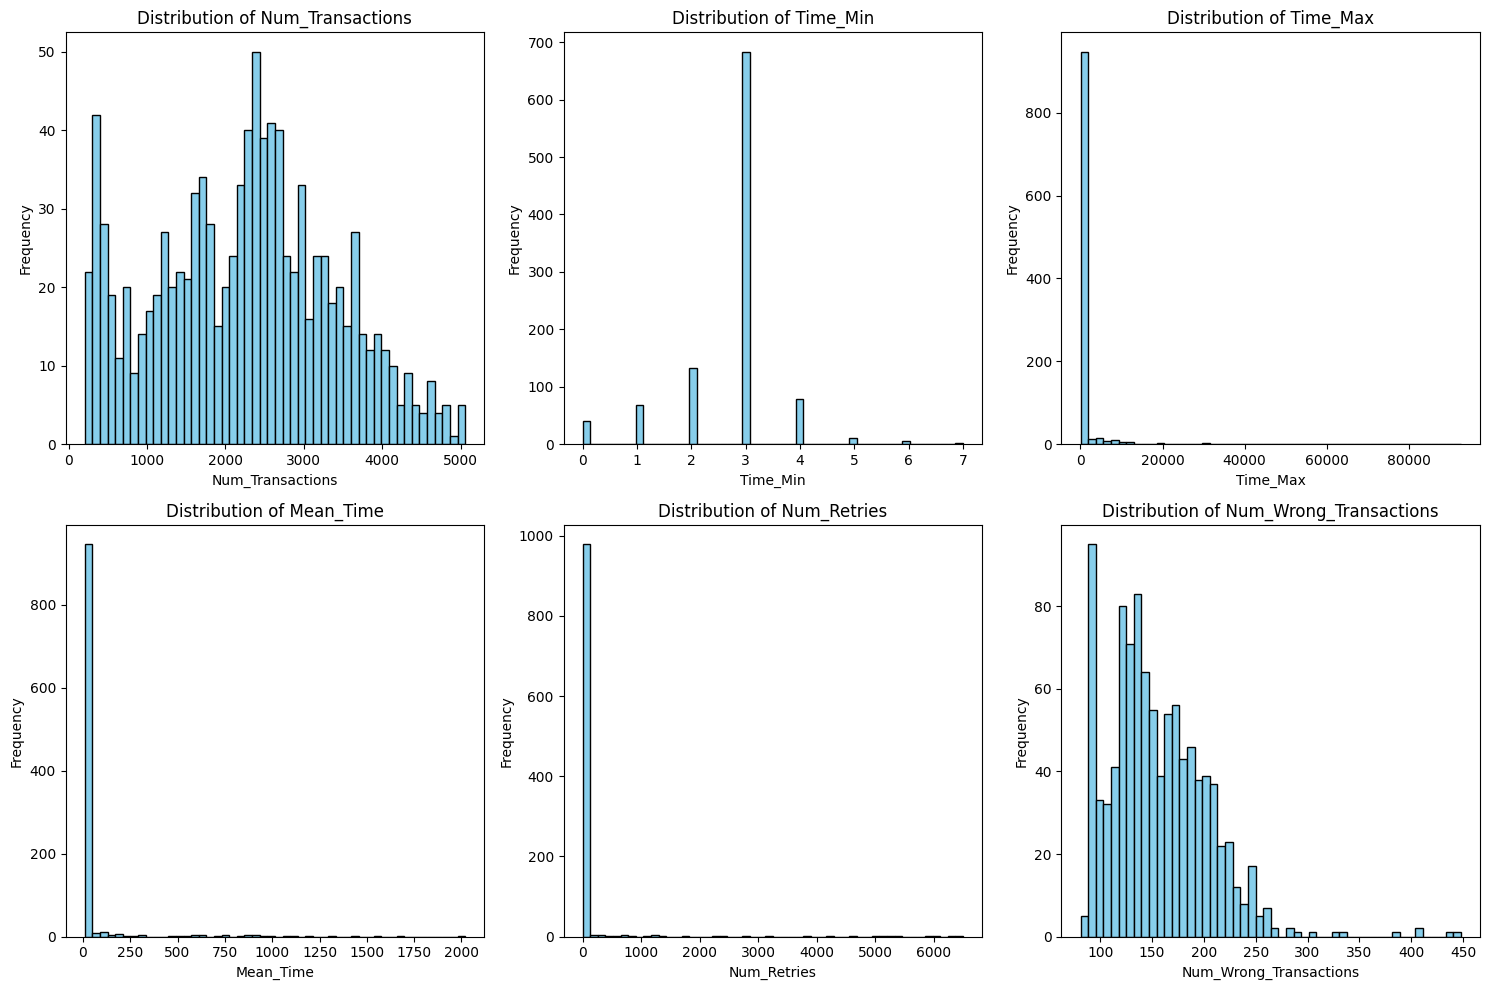

Data Shape: (1018, 10)

Data Types:
 Code_ID                            int64
Timestamp                 datetime64[ns]
Interval_s                         int64
Num_Transactions                   int64
Time_Min                           int64
Time_Max                           int64
Mean_Time                        float64
Num_Retries                        int64
Num_Wrong_Transactions             int64
Rolling_STD                       object
dtype: object

Missing Values:
 Code_ID                    0
Timestamp                  0
Interval_s                 0
Num_Transactions           0
Time_Min                   0
Time_Max                   0
Mean_Time                  0
Num_Retries                0
Num_Wrong_Transactions     0
Rolling_STD               14
dtype: int64

Descriptive Statistics for Numerical Features:
        Num_Transactions     Time_Min      Time_Max    Mean_Time  Num_Retries  \
count       1018.000000  1018.000000   1018.000000  1018.000000  1018.000000   
mean     

In [ ]:
# Data Shape and Types
data_shape = raw_df.shape
data_types = raw_df.dtypes

# Missing Values
missing_values =  raw_df.isnull().sum()

# Feature Analysis
numerical_features = ['Num_Transactions', 'Time_Min', 'Time_Max', 'Mean_Time', 'Num_Retries', 'Num_Wrong_Transactions']
descriptive_stats =  raw_df[numerical_features].describe()

# Data Distribution and Potential Outliers (Histograms)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    plt.hist( raw_df[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./images/00-histograms-of-variables.png")
plt.show()

# Document Findings
print("Data Shape:", data_shape)
print("\nData Types:\n", data_types)
print("\nMissing Values:\n", missing_values)
print("\nDescriptive Statistics for Numerical Features:\n", descriptive_stats)

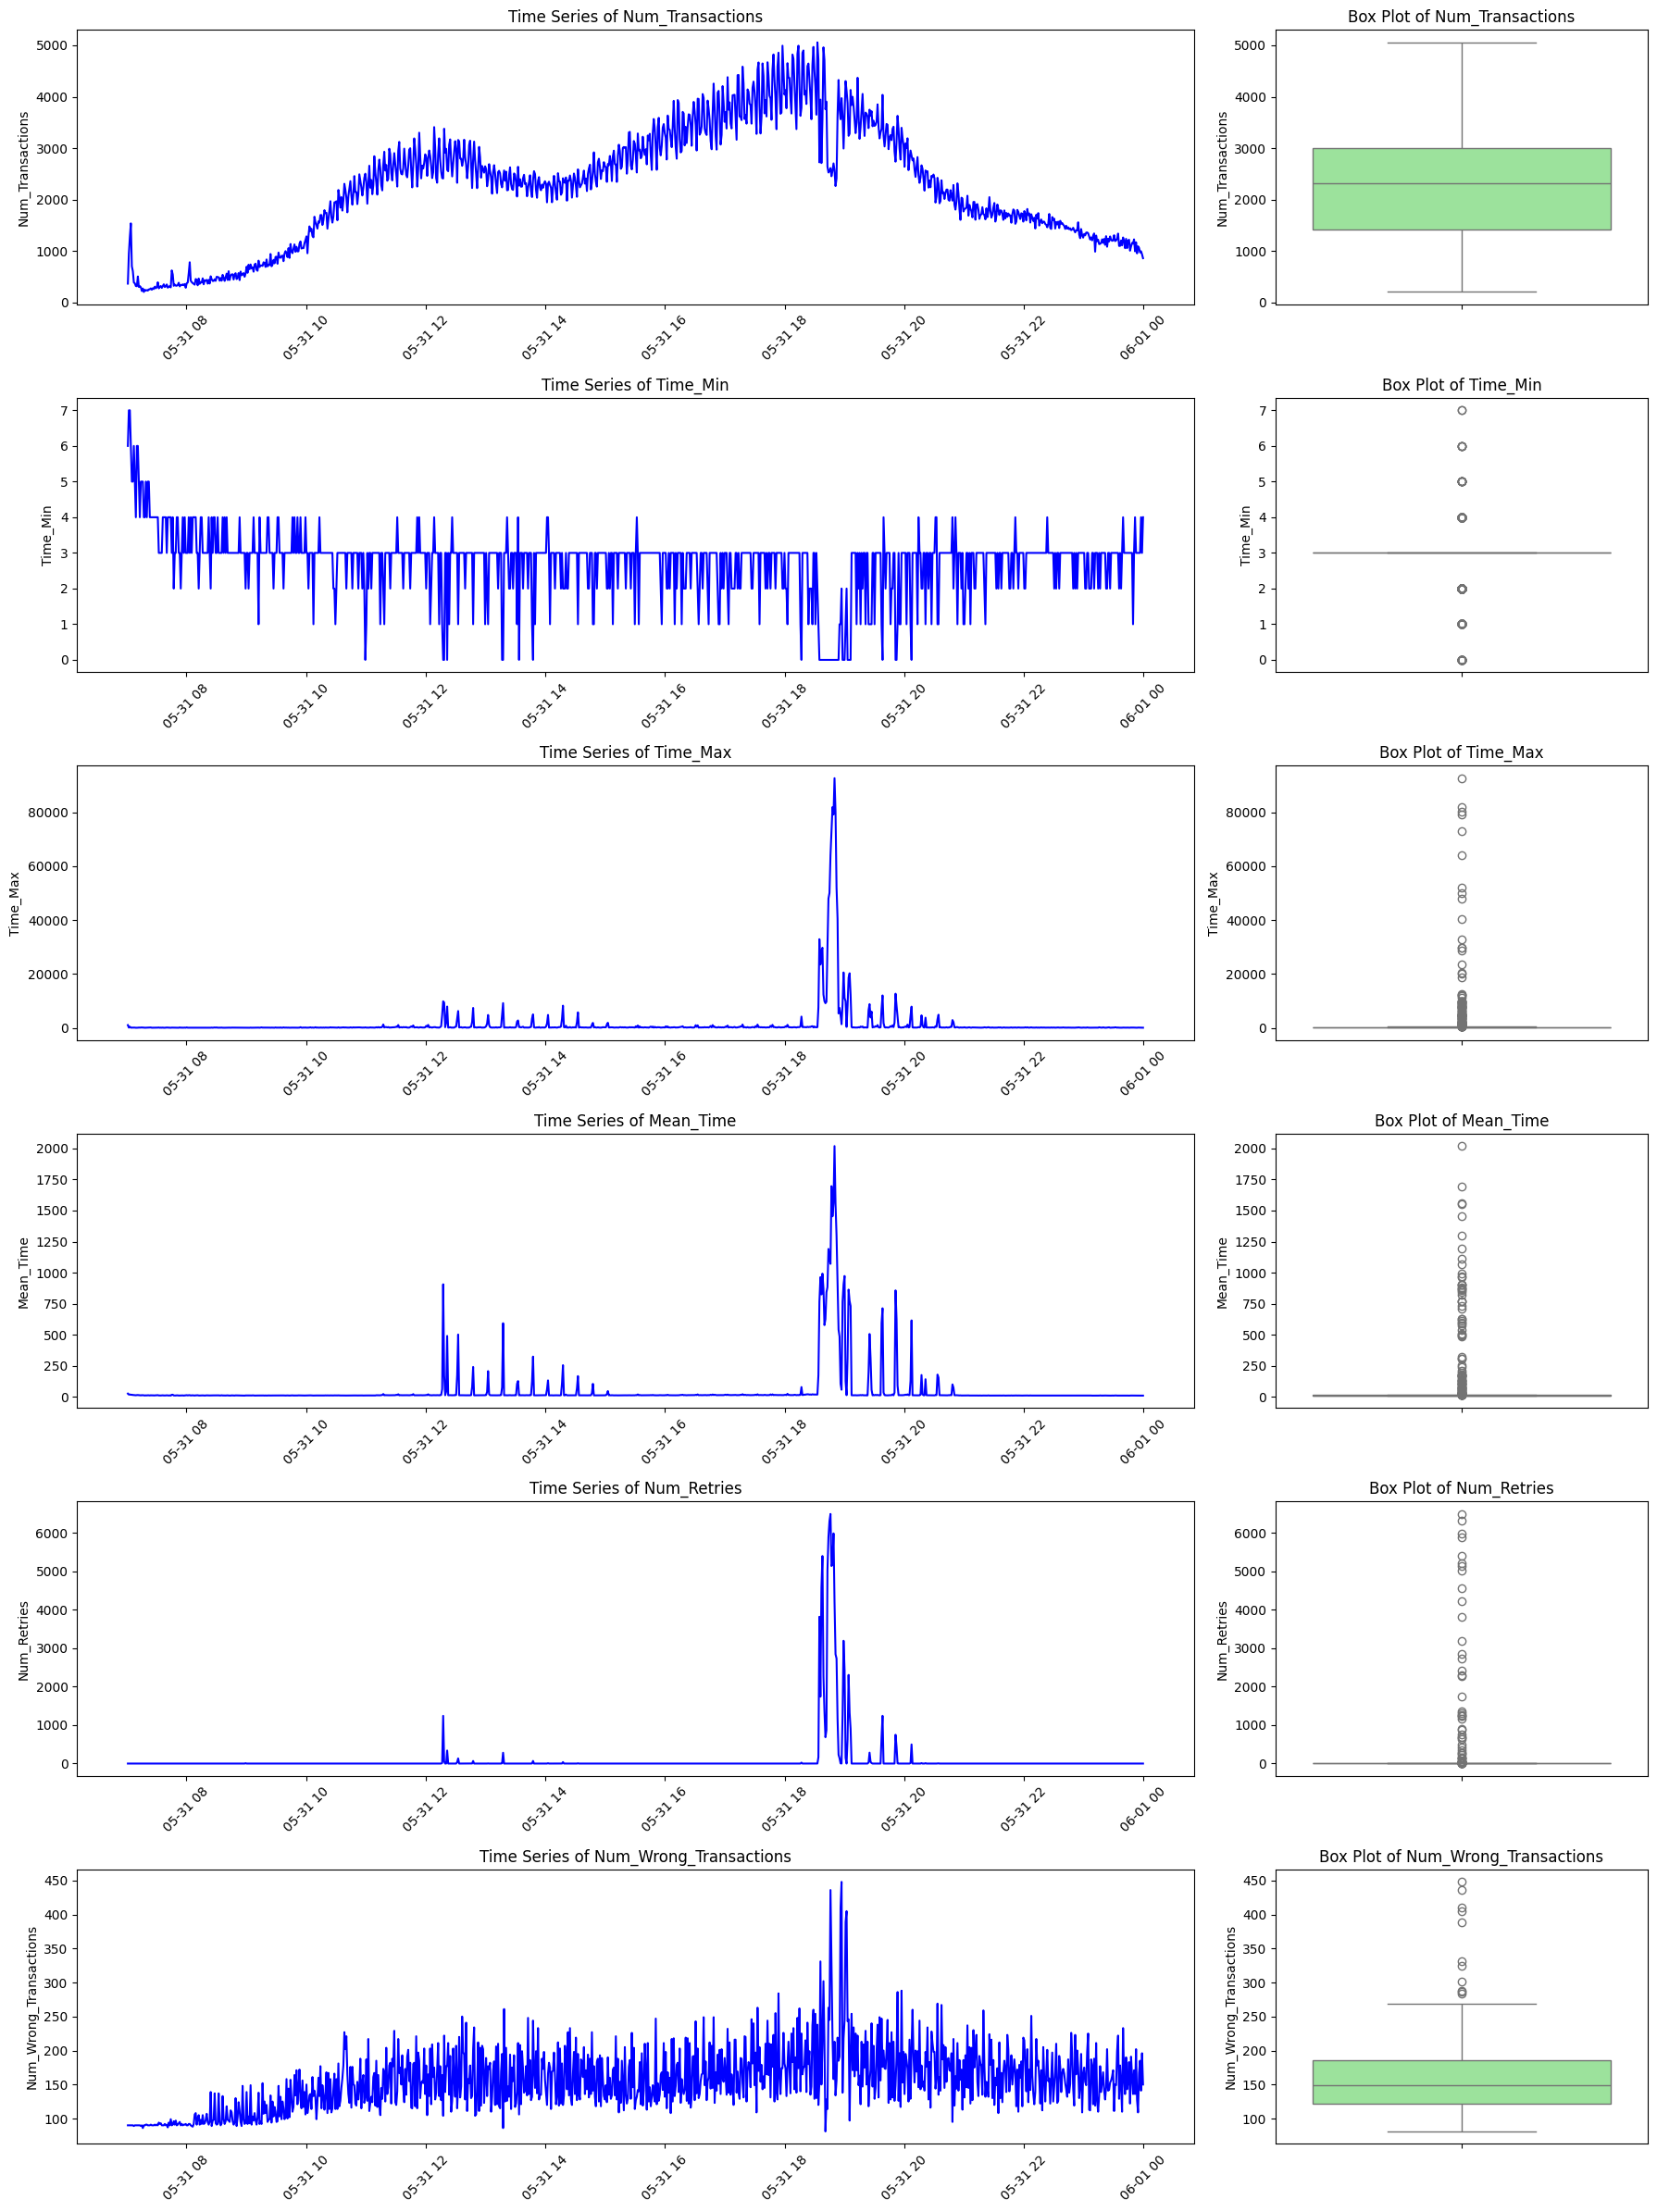

In [ ]:
#time series plots for observing normal and unusual patterns

fig, axs = plt.subplots(len(numerical_features), 2, figsize=(18, 4 * len(numerical_features)), 
                       gridspec_kw={'width_ratios': [3, 1]})

for i, feature in enumerate(numerical_features):
    # Time series plot
    axs[i, 0].plot(raw_df['Timestamp'], raw_df[feature], color='blue')
    axs[i, 0].set_title(f'Time Series of {feature}')
    
    axs[i, 0].set_ylabel(feature)
    axs[i, 0].tick_params(axis='x', rotation=45)
    
    # Rotated (vertical) box plot
    sns.boxplot(y=raw_df[feature], ax=axs[i, 1], color='lightgreen', orient='v')
    axs[i, 1].set_title(f'Box Plot of {feature}')
    axs[i, 1].set_ylabel(feature)

plt.tight_layout()
plt.savefig("./images/01-time-series-and-boxplots.png")
plt.show()

The **box plot of `Num_Transactions`** helps detect any unusual spikes in transaction counts that could point to system stress or unexpected user behavior. From the plot, we observe that the number of transactions generally ranges between approximately 1000 and 3000. However, there are several high outliers, with some intervals exceeding 5000 transactions. This indicates that while the system normally processes a moderate volume, there are certain periods with exceptionally high activity that may require further investigation.

The **box plot of `Time_Min`** was included to assess the shortest processing time recorded in each interval. This helps in identifying any unexpected low values that might indicate abnormalities in transaction handling. The plot shows that most minimum processing times are around 3 units, with a few lower outliers down to 0 or 1 and above 4. These low values could be artifacts of data collection or represent failed or incomplete transactions that bypassed the standard processing time. Interesting point about `Time_Min` is that whenever it is under 1, other metrics starts to spike or arise which can be a sign of being abnormal.

The **box plot of `Time_Max`** was used to capture the upper bound of transaction processing time in each interval. By analyzing this, we can detect performance bottlenecks or problematic transactions that take abnormally long to complete. The majority of values are tightly clustered near the bottom, suggesting that most transactions are processed within a reasonable timeframe. However, the plot reveals a large number of extreme outliers, with some maximum times exceeding 80,000 units. These spikes are clear red flags for performance issues and could signal underlying system failures or data anomalies during those intervals.

The **box plot of `Mean_Time`** provides insights into the average processing time per interval. This metric is essential for evaluating the system's overall efficiency and consistency. The box plot shows a tightly packed distribution near the lower end, indicating that most intervals have a low average transaction time. Nevertheless, a number of high outliers are present, with some intervals showing mean times above 1500 or even 2000 units. Such spikes could point to transient performance issues, congestion, or specific transactions that are disproportionately slowing down the system and can be seen as abnormal ones.

The **box plot of `Num_Retries`** was plotted to understand how frequently the system had to retry transactions. High retry counts can be symptomatic of instability, errors, or external service issues. The majority of the data is concentrated near zero retries, which is a positive indicator of system reliability. However, the presence of many high outliers—some exceeding 6000 retries in a single interval—indicates occasional severe disruptions that require attention. These anomalies may align with periods of heavy system load or technical malfunctions.

Lastly, the **box plot of `Num_Wrong_Transactions`** was used to examine how often transactions fail to complete successfully. Monitoring this variable is critical for ensuring service reliability and user satisfaction. The distribution shows that most values fall between 100 and 200, with a relatively moderate interquartile range. Nonetheless, several high outliers are present, with failed transactions reaching above 450 in some intervals. These failure spikes may correlate with the high retry rates and processing time anomalies seen in other plots, offering a potential direction for root-cause analysis.


In [ ]:
## individual time series plots for observing normal and unusual patterns

# for feature in numerical_features:
#     fig, axs = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})
    
#     # Time series plot
#     axs[0].plot(raw_df['Timestamp'], raw_df[feature], color='blue')
#     axs[0].set_title(f'Time Series of {feature}')
#     axs[0].set_xlabel('Timestamp')
#     axs[0].set_ylabel(feature)
#     axs[0].tick_params(axis='x', rotation=45)
    
#     # Box plot
#     sns.boxplot(x=raw_df[feature], ax=axs[1], color='lightgreen', orient='h')
#     axs[1].set_title(f'Box Plot of {feature}')
#     axs[1].set_xlabel(feature)
    
#     plt.tight_layout()
#     plt.show()
    

#--------------------------------

## Plot each variable's time series and its box plot in the same figure, one by one

# for feature in numerical_features:
#     fig, axs = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})
    
#     # Time series plot
#     axs[0].plot(raw_df['Timestamp'], raw_df[feature], color='blue')
#     axs[0].set_title(f'Time Series of {feature}')
#     axs[0].set_xlabel('Timestamp')
#     axs[0].set_ylabel(feature)
#     axs[0].tick_params(axis='x', rotation=45)
    
#     # Box plot
#     sns.boxplot(x=raw_df[feature], ax=axs[1], color='lightgreen', orient='h')
#     axs[1].set_title(f'Box Plot of {feature}')
#     axs[1].set_xlabel(feature)
    
#     plt.tight_layout()
#     plt.show())

    

## 1.3 EDA

In this section we visualize the relationships between variables using correlations, box and line plots to gain further insights.

We observed that the number of transactions over time does not follow a consistent trend. Instead, it fluctuates in a zigzag pattern between intervals. Additionally, we noticed that the amplitude of these fluctuations increases during specific times of the day, for example, between 10 AM and 1 PM, and peaks around 6 PM before starting to decline.

To better understand this behavior over time, we decided to plot the rolling variance of the number of transactions using a 15-minute window (i.e., 15 time intervals). This allows us to observe changes in variability throughout the day more clearly.

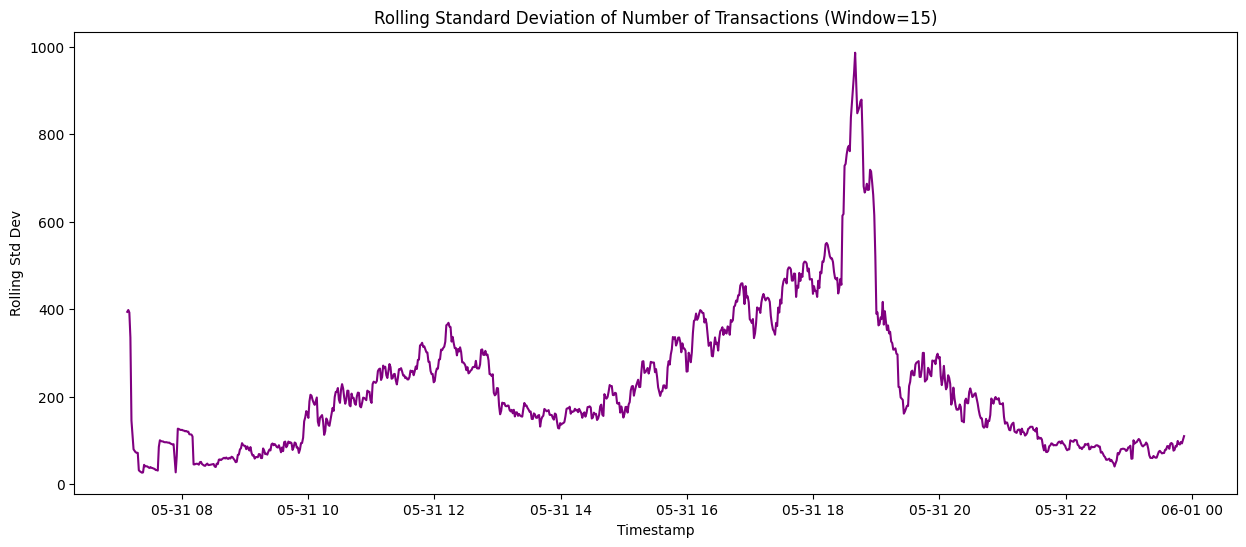

In [ ]:
# Calculate the standard deviation for number of transactions over time

window=15 # 15 minutes rolling window
rolling_std = raw_df['Num_Transactions'].rolling(window=window).std()
rolling_std = rolling_std[14:]

# Plot the rolling standard deviation
plt.figure(figsize=(15, 6))
plt.plot(raw_df.iloc[7:-7]['Timestamp'], rolling_std, color='purple') # adjusting for the rolling window
plt.title(f'Rolling Standard Deviation of Number of Transactions (Window={window})')
plt.xlabel('Timestamp')
plt.ylabel('Rolling Std Dev')
plt.savefig(f"./images/02-rolling-standard-deviation.png")
plt.show()

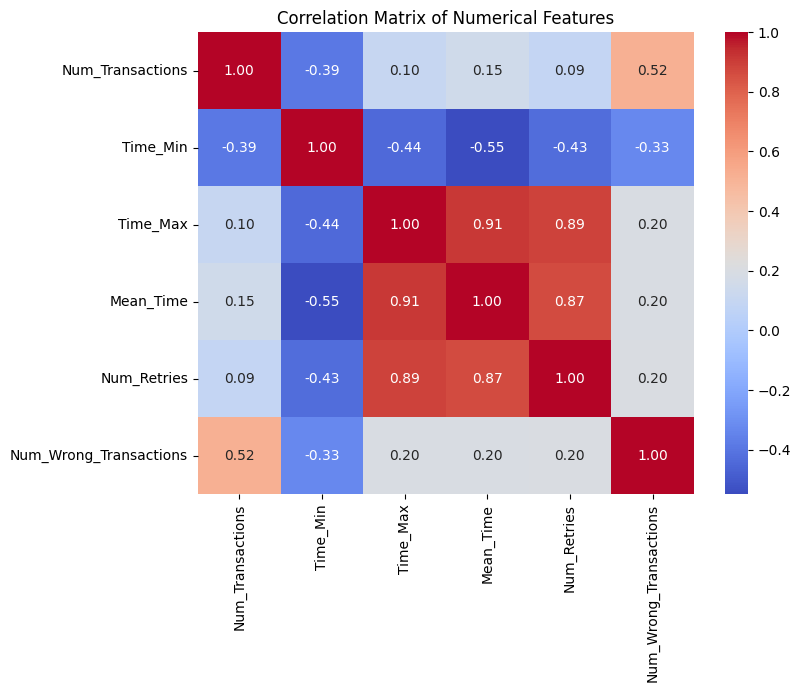

In [ ]:
# Correlation Analysis

plt.figure(figsize=(8, 6))
correlation_matrix = raw_df[['Num_Transactions', 'Time_Min', 'Time_Max', 'Mean_Time', 'Num_Retries', 'Num_Wrong_Transactions']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.savefig("./images/03-correlation-matrix.png")
plt.show()

It is notable that **`Time_Min` shows a moderate negative correlation with most other features**, particularly with `Mean_Time` (-0.55), `Time_Max` (-0.44), and `Num_Retries` (-0.43). This implies that when the minimum transaction time decreases, that happens mostly in crowded times of system to process the transactions faster, the overall system tends to perform worse, with more retries and higher average or maximum durations. To recap, lower `Time_Min` values are associated with more variability and potential instability in transaction processing.


In [126]:
# # Scatter Plots
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.scatter(raw_df['Num_Transactions'], raw_df['Mean_Time'], color='orange')
# plt.title('Num_Transactions vs. Mean_Time')
# plt.xlabel('Num_Transactions')
# plt.ylabel('Mean_Time')

# plt.subplot(1, 2, 2)
# plt.scatter(y=raw_df['Num_Retries'], x=raw_df['Num_Wrong_Transactions'], color='purple')
# plt.title('Num_Wrong_Transactions vs. Num_Retries')
# plt.ylabel('Num_Retries')
# plt.xlabel('Num_Wrong_Transactions')

# plt.tight_layout()
# plt.show()

This time series plot provides a view of the trends in three key variables: **`Num_Transactions`**, **`Mean_Time`**, and **`Time_Min`**, with smoothing techniques applied through a rolling window of size 10. The variables are visualized with different scaling to allow for meaningful comparisons on the same axis.

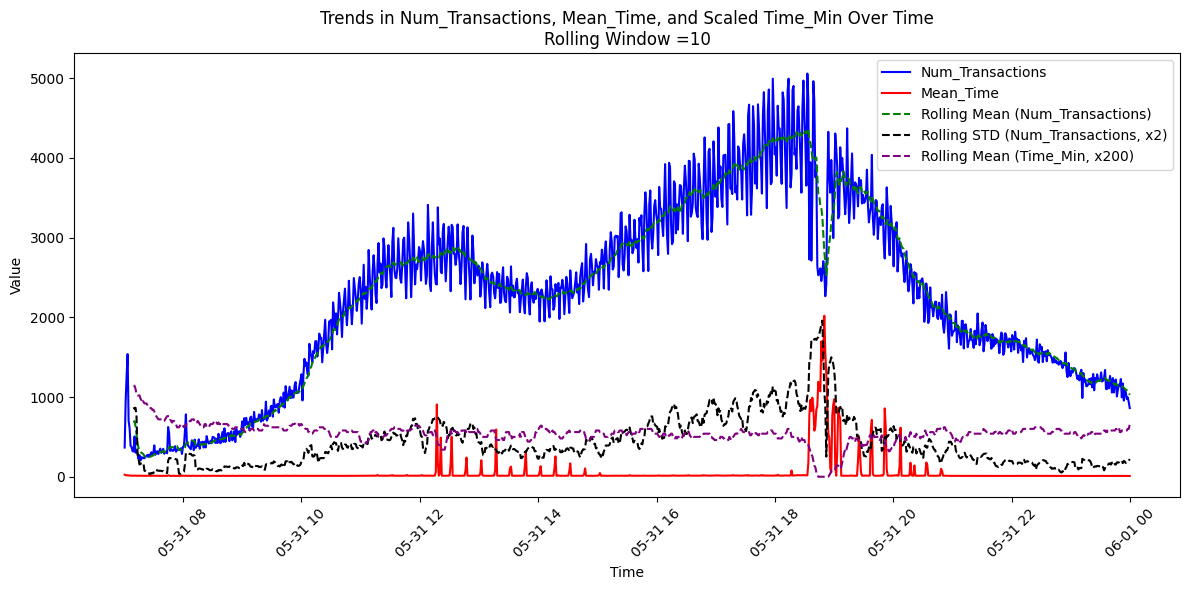

In [ ]:
# Trends in Num_Transactions with its Rolling STD, Mean_Time and Scaled Time_Min

plt.figure(figsize=(12, 6))

# Convert 'Timestamp' to datetime objects
raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
raw_df = raw_df.dropna(subset=['Timestamp'])  # remove rows with invalid date values

# Plotting the time series
plt.plot(raw_df['Timestamp'], raw_df['Num_Transactions'], label='Num_Transactions', color='blue')
plt.plot(raw_df['Timestamp'], raw_df['Mean_Time'], label='Mean_Time', color='red')


# Rolling mean
window = 10
plt.plot(raw_df['Timestamp'], raw_df['Num_Transactions'].rolling(window=window).mean(), label='Rolling Mean (Num_Transactions)', color='green', linestyle='--')
plt.plot(raw_df['Timestamp'], raw_df['Num_Transactions'].rolling(window=window).std()*2, label='Rolling STD (Num_Transactions, x2)', color='black', linestyle='--')

#plt.plot(raw_df['Timestamp'], raw_df['Mean_Time'].rolling(window=window).mean(), label='Rolling Mean (Mean_Time)', color='orange', linestyle='--')
plt.plot(raw_df['Timestamp'], raw_df['Time_Min'].rolling(window=window).mean() * 200, label='Rolling Mean (Time_Min, x200)', color='purple', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Trends in Num_Transactions, Mean_Time, and Scaled Time_Min Over Time\nRolling Window ={window}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"./images/04-trends.png")
plt.show()

This time series plot provides a view of the trends in three key variables: **`Num_Transactions`**, **`Mean_Time`**, and **`Time_Min`**, with smoothing techniques applied through a rolling window of size 10. The variables are visualized with different scaling to allow for meaningful comparisons on the same axis.

The **blue line represents `Num_Transactions`**, showing the number of transactions recorded at each time interval. A clear upward trend is visible throughout the early part of the day, peaking around 18:00. After this peak, the number of transactions steadily declines. This suggests a daily pattern that we have to take care while we are generating new data. 

The **green dashed line**, which is the rolling mean of `Num_Transactions`, smooths the short-term fluctuations and confirms the overall pattern of rising and then falling transaction volume. In addition, the **black dashed line** shows the rolling standard deviation (multiplied by 2 for visibility), which increases alongside transaction volume. This indicates that periods of high activity also exhibit greater variability.

The **red line corresponds to `Mean_Time`**, reflecting the average processing time per interval. This variable remains low and stable for much of the day but displays sudden sharp spikes, particularly after 17:30. These peaks are brief but pronounced, suggesting isolated intervals where performance issues arose. This could be due to system overload, or anomalies.

To add further context, **`Time_Min`** is included as the **magenta dashed line**, scaled by a factor of 200 to match the vertical range of the other metrics. Although this variable is relatively flat throughout the day, there is a slight downward trend in the morning followed by mild fluctuations. This stability contrasts with the more volatile behavior of `Mean_Time` and `Num_Transactions`, implying that while individual transactions may occasionally process instantly (Time\_Min), the average system performance is more sensitive to load.


## 1.4 Summary:


The analysis helped us understand the nature of the dataset and the potenial anomalies in a transaction dataset. Based on the analysis, potential anomalies might be outliers in `Time_Max` (unusually long transaction processing times),`Time_Min` (when it decreases to 0 and it happens when number of transactions are unusually high) and `Num_Retries` (periods of high system instability). Trends in `Num_Transactions` and `Mean_Time` should be examined for spikes, dips, or consistent patterns that might indicate bottlenecks or periods of low activity.

Insights for Next Steps:

* **Investigating Outliers:** In next steps we will dive into the instances flagged as potential outliers in `Time_Max` and `Num_Retries` to determine their root causes. Are these genuine anomalies, or are they due to expected system behavior under specific conditions?
We will apply anomaly detection algorithm to the dataset to identify statistically significant deviations from normal behavior.
